In [1]:
## Setup Notebook

# Notebook Theme
from IPython.core.display import HTML
HTML('style.css')

In [2]:
from __future__ import print_function

import seaborn as sns
import tensorflow as tf
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad
from scipy.optimize import fmin_l_bfgs_b

from neural_net import FullyConnectedNet, \
get_nonlinear_funcs, generate_data, error_surface,final_error, plot_surface, plot_approximations

# Plotting
%matplotlib inline
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For MB Pro retina display
%config InlineBackend.figure_format = 'retina'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

/Users/aandonia/anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<div class='markdown-body'>
<div style='float:right;'>
<img src='mlp.png' width='350px'style="display: inline-block; margin-left: 0px; float: right;">
</div>

# Neural Networks and Parameter Optimization

### In this notebook, we will explore the concept of neural networks and parameter optimization. For a brief introduction, please refer to the following:

- [Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network)
- [Optimization](http://scipy-lectures.github.io/advanced/mathematical_optimization)
- [Approximation](https://en.wikipedia.org/wiki/Universal_approximation_theorem)

##### Problem: First using Python and `numpy`, and then using `tensorflow`, implement a three-layer neural network and optimize its parameters to fit nonlinear functions. Investigate and characterize the dependence of the fitting ability on the number of network parameters.

**1.** Write a function that implements the neural network, as a function of input stimulus $x$ and network parameters $b_0$, $w_1$, $b_1$, $w_2$, and $b_2$, where the $b_i$ are the biases at each layer and the $w_i$s are the weights. Specifically, your function should implement:

$$F(x) = (A((x + b_0) * w_1) + b_1) * w_2 + b_2$$

In this equation, $A$ is a scalar activation function (typically the hyperbolic tangent tanh), $*$ means matrix multiplication, $x$ is a vector of length $N$, $b_0$ is a vector of length $N$, $w_1$ is a matrix of shape $(N, I)$, $b_1$ is a vector of length $I$, $w_2$ is a matrix of shape $(I, O)$ and $b_2$ is a vector of shape $O$ (These symbols are chosen of '$N$' = 'input', '$I$' = 'intermediate', and ’$O$’ = ’output’.) Your function should operate on `numpy` array objects and use efficient `numpy` array operations.

### Implementing a Neural Network
We will use the class `FullyConnectedNet` in the file `neural_net.py` to represent instances of a feed-forward, fully-connected (dense/affine) neural network with an arbitrary number of hidden layers, activations functions (nonlinearlities) and regularized cost. A network with $L$ layers ***(not including the input nodes/layer)*** has an input dimension of $N$, hidden layer dimensions of $I_l$ with $l = 1, 2, \dots, (L-1)$, and performs approximations over $O$ classes (non-linear functions in this case). We train the network with a mean squared error loss function and L2 regularization on the final weight matrix. The network uses a `ReLU` nonlinearity (by default) after all but the last fully connected layer. Therefore, the architecture will be:

        Input (N) --> {affine - relu [ml nl]} x (L - 1) --> {affine - loss [nL O]} --> Outputs (O)

        where (ml, nl) = w_l.shape and the {...} block is repeated L - 1 times.

The output $F(X)_i$ of the last fully-connected layer is the approximatimations for nonlinear function $h_i$ evaluated at all the points in $x$. When using the `scipy` optimization backend, the network parameters are stored in the instance variable `self.params` as a single $n \times 1$ `numpy` array, where $n = \sum_{l}^L(w_l.shape[0] + 1)*w_l.shape[1]$, the total number of model parameters (weights + biases) in the network. It is stored as a 1D vector because `L_BFGS_B` optimizes over a 1D vector, and is reshaped into weight/biases matrices to make the forward pass. To initialize the model, we create an instance of the `FullyConnectedNet` class, which calls the `FullyConnectedNet.init_params` method during `__init__()`. `FullyConnectedNet.init_params` then calls the following subroutine when the `scipy` backend is being used:
```python
   def _scipy_init_params(self):
        """ Generate a list of weight matrices, one for each layer. """

        b0_size = self.layer_sizes[0]
        lshapes_with_bias = [[l[0] + 1, l[1]] for l in self.layer_shapes]

        # List (m + 1) x n parameter arrays for each layer (+1 for bias)
        params = [np.random.randn(m, n) * np.sqrt(2.0 / m) for m, n in lshapes_with_bias]
        b0 = [np.random.random(b0_size) * np.sqrt(2.0 / b0_size)]
        return self._scipy_flatten_params(b0 + params)
```

In [3]:
## Create a 2 layer (not including input) net to represent our function F(X)
## and display its (default) properties:

# For repeatability
np.random.seed(1)

# Network architecture
input_size = 100   # N = 100
hidden_size = 100  # I = 100
output_size = 7    # O = 7
layer_sizes = [input_size, hidden_size, output_size]

# Init and display
net = FullyConnectedNet(layer_sizes)
print(net)

Feed-Forward Neural Network with 2 Fully-Connected Layers 
Activation function: Rectified Linear Units (ReLU) 
Loss/Cost function: Regularized Least Squares 
Backend Optimization: Scipy L-BFGS-B 
Network Diagram: 
                 -------- Layer 1 --------      -------- Layer 2 --------      
Inputs (100) --> {affine - relu [100, 100]} --> {affine - reg_mse [100, 7]} --> Outputs (7)


<div class='markdown-body'>
### Forward pass: compute output
In the file `neural_net.py`, we have implemented the instance method `FullyConnectedNet.forward_pass`, which calls the appropriate subroutine based on the current backend. Given some data `input`, this method uses the weights and biases stored in `self.params` to compute the output $F(X)$ of the network. For convenience, it also returns $w_2$ to be used in computing the *regularized least squares* cost in part 2.

```python
   def _scipy_forward_pass(self, input, params=None):
        """ Compute the forward pass of a neural network given an input `input`. """

        if params is None:
            params = self.params

        sparams = self._scipy_shape_params(params)
        input = input + sparams[0]
        for wb in sparams[1:]:
            output = np.dot(input, wb[:-1, :])         #  wb[:-1, :]: w_i (weights)
            input = np.maximum(0, output) + wb[-1, :]  #  wb[-1, :]: b_i (biases)
        return output, sparams[-1][-1, :]
```

<div class='markdown-body'>
**2.** Define a cost function `Cost` that assesses how well a given setting of the parameters
$(b_0, w_1, b_1, w_2, b_2)$ does at allowing several non-linear functions to be approximated by the
neural network embodied by the function F. Specifically, you should define a *regularized
least squares* cost function of the form:

$$Cost((b_0, w_1, b_1, w_2, b_2), X, Y ) = mean[(F(X) - Y )^2] + C * ||w_2||^2$$

where $C$ is a positive scalar and $||\cdot||^2$ denotes square-vector norm. This function produced
a large value when $F(X)$ differs from $Y$ , but it penalizes large values in the coefficients
of the intermediate layer, e.g. the cost increases when $w_2$ has large norm.
Again your function should be implemented via `numpy` and it should be efficient.

### Forward pass: compute loss
We have implemented the instance method `FeedForwardNet.Cost`. This method makes a forward pass with `X` and computes the *regularized least squares* loss with respect to `params` given the corresponding `Y`.

```python
 def _scipy_cost(self, params, X, Y, C=None):

        C = 1 if C is None else C
        out, w2 = self._scipy_forward_pass(X, params)
        error = np.mean(np.power((out - Y), 2))
        cost = error + C * np.square(np.linalg.norm(w2))
        return cost
```


<div class='markdown-body'>
**3.** Define a function `dCost` that evaluates the derivative of the cost function with respect to the variables $b_0, w_2, b_1, w_2$ and $b_2$. In other words, your function should return as a
`numpy` array the partial derivatives $\partial Cost /\partial v$ for each variable $v$. You might find the
package `PyAutoDiff` helpful here and the next problem section, as well.

### Backward pass
To compute the gradient of the loss with respect to the variables `b0`, `Wi`, `bi` with $i = 1, \dots, L$ we make use of the <code><a href=https://github.com/HIPS/autograd>autograd</a></code> Python package to automatically differentiate our cost function:
```python
    def dCost(self, params, X, Y, C=1):
        f = grad(self._scipy_cost)
        return f(params, X, Y, C)
```

<div class='markdown-body'>
**4.** Using the optimization tool `L-BFGS-B` provided in the the `scipy` optimization package,
optimize the parameters of the neural network to approximate the following nonlinear functions:
- $h_1(x) = x^2$
- $h_2(x) = x^3 - 10x^2 + x - 1$
- $h_3(x) = x^{3/2} - 20x^{0.5} + 2 * x + 2$
- $h_4(x) = 3x^{5/2} - 20x^{0.3} - 10x + 5$
- $h_5(x) = \sin(\pi x)$
- $h_6(x) = \cos(\pi x)$
- $h_7(x) = \sin(2 * \pi x)$
- $h_8(x) = \tan(\pi * (x + 0.5))$

You should perform this approximation on the interval between $0$ and $10$, and evaluate your results at intervals of $0.1$ units. Your network should have $N = 100$ input nodes. Since there are $8$ nonlinear functions above, your network should have $O = 8$ outputs. The number of intermediate nodes is up to you. Set regularization constant $C = 1$. Specifically, you want to run an optimization like:

```python
result = scipy.optimize.fmin l_bfgs_b(Cost, x0=(b0_0, w1_0, b1_0, w2_0, b2_0),
                                            fprime=dCost,
                                            args=(X, Y))
```
where $X$ is the array `np.tile(np.arange(0, 10, .1), (N, 1))`, and $Y$ is
the data array `[h_i(x) for x in np.arange(0, 10, .1)]`, and $b0_0, w1_0, b1_0, w2_0, b2_0$ are initial random guesses for your parameter values.


We begin by defining some utility functions to help generate the training data. *Note: On the intervale [0, 10], $h_8(x) = \tan(\pi * (x + 0.5))$ asymptotically approaches $ \pm \infty$ at integer multiples of $\frac{1}{2}$ (i.e. it has many discontinuities on this interval). Therefore, the Universal Approximation Theorem does not guarantee that a neural network is able to approximate this function to arbitrary precision. In practice, this function makes convergence/training very difficult because initial errors are extremely large (on the order of `1e31`. We will continue without this function.


In [4]:
## Define utility functions to help us generate training data

def get_nonlinear_funcs():
    funcs = [lambda x: np.power(x, 2),
             lambda x: np.power(x, 3) - (10 * np.power(x, 2)) + x - 1,
             lambda x: np.power(x, 3.0 / 2.0) - 20 * (np.power(x, 0.5)) + (2 * x) + 2,
             lambda x: 3 * np.power(x, 5.0 / 2.0) - (20 * np.power(x, 0.3)) - (10 * x) + 5,
             lambda x: np.sin(np.pi * x),
             lambda x: np.cos(np.pi * x),
             lambda x: np.sin(2 * np.pi * x)]
#              lambda x: np.tan(np.pi*(x + 0.5))]  # See the note above.
    return funcs

def generate_data(input_size, funcs=get_nonlinear_funcs()):

    X = np.tile(np.arange(0, 10, 0.1), (input_size, 1)).T
    Y = np.hstack([np.array(f(X[:, 0])).reshape(-1, 1)
                   for f in funcs])
    return X, Y

<div class='markdown-body'>
### Train the network
To train the network, we will first using `scipy`'s implementation of the *Limited Memory BFGS (Broyden-Fletcher-Goldfarb-Shanno algorithm)*, an iterative, quasi-Newton numerical optimization algorithm for solving unconstrained non-linear optimization problems. As an approximation to Newton's method, BFGS seeks a local stationary point of a function by iteratively refining approximations of the *Hessian* (matrix of second derivatives) at each iteration.  For this class of hill-climbing optimization techniques, a gradient of ~ zero is a necessary condition for optimality. Below, we supply the algorithm with training data $(X, Y)$, an initial approximation, and cost function and its gradient to be minimized with repect to the parameters of the network:

In [5]:
## Train the network via the Limited Memory BFGS (Broyden-Fletcher-Goldfarb-Shanno algorithm)

# Generate training data
X, Y = generate_data(net.layer_sizes[0])

# Perform optimization (training) using SciPy's L_BFGS_B fmin routine
training_stats = net.train(X, Y, backend='scipy', verbose=True)

Using scipy for training
iter: 0 / 50000; current error = 8396.624207711; current cost = 8396.762990657
iter: 1000 / 50000; current error = 0.096205639; current cost = 0.096367010
iter: 2000 / 50000; current error = 0.041557042; current cost = 0.041557191
iter: 3000 / 50000; current error = 0.016166794; current cost = 0.016166817
iter: 4000 / 50000; current error = 0.009069933; current cost = 0.009069936
iter: 5000 / 50000; current error = 0.007636702; current cost = 0.007636776
iter: 6000 / 50000; current error = 0.006868968; current cost = 0.006868968
iter: 7000 / 50000; current error = 0.006545605; current cost = 0.006545605
iter: 8000 / 50000; current error = 0.006296923; current cost = 0.006296923
iter: 9000 / 50000; current error = 0.006164440; current cost = 0.006164441
iter: 10000 / 50000; current error = 0.005987792; current cost = 0.005987792
iter: 11000 / 50000; current error = 0.005926808; current cost = 0.005926808
iter: 12000 / 50000; current error = 0.005761135; current 

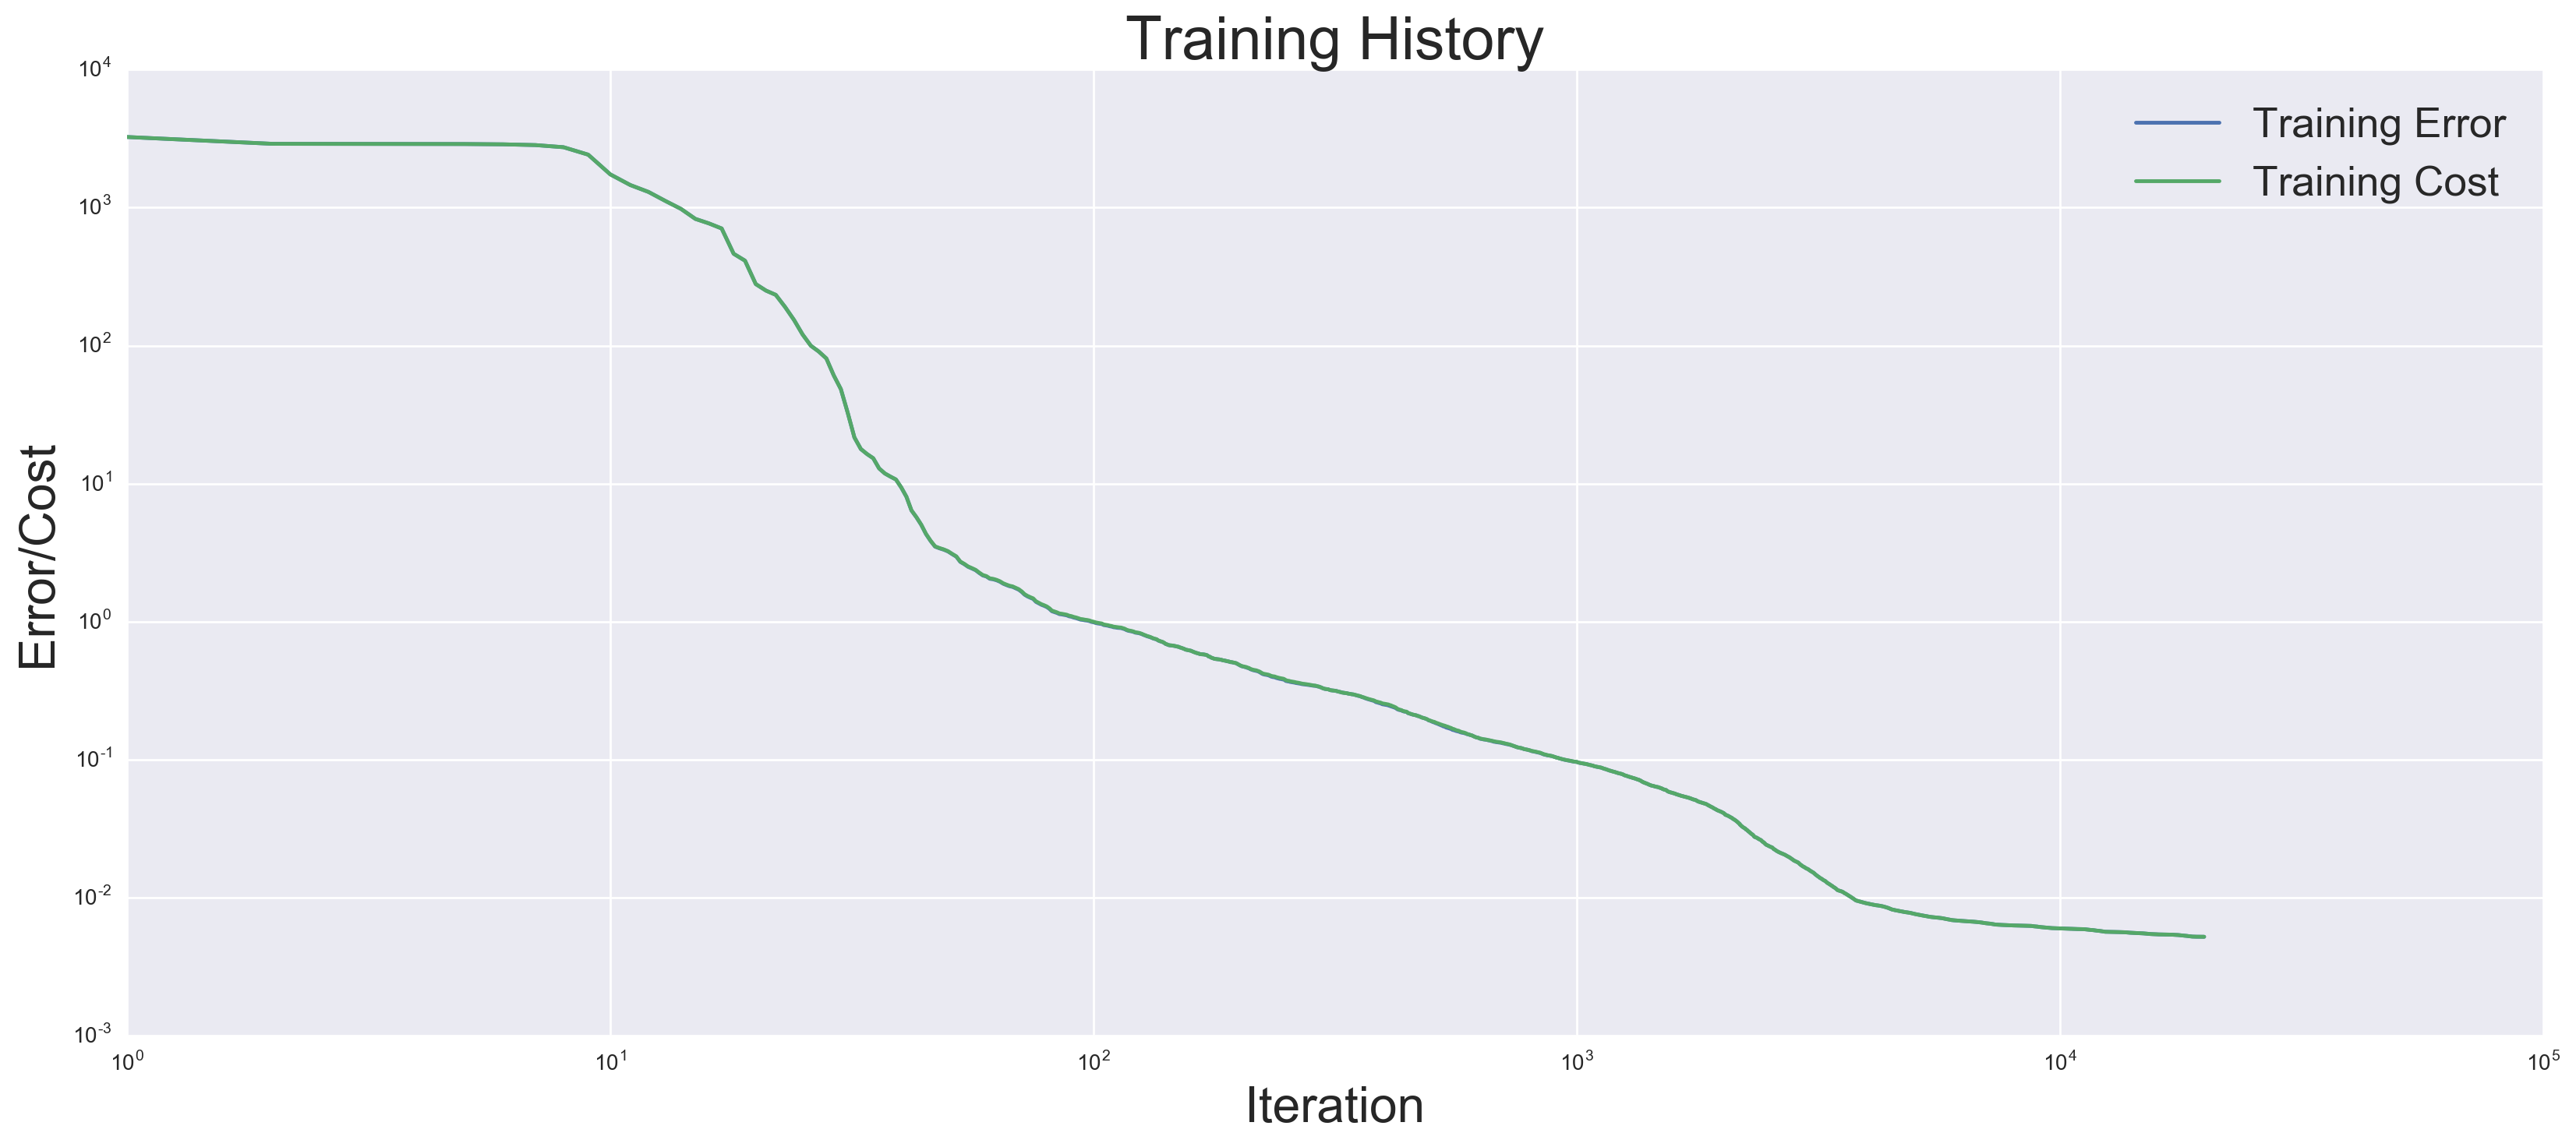

In [6]:
## Plot loglog plot of training history:

plt.loglog(training_stats['error_history'], label='Training Error')
plt.loglog(training_stats['cost_history'], label='Training Cost')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Iteration', fontsize='x-large')
plt.ylabel('Error/Cost', fontsize='x-large')
plt.title('Training History', fontsize='xx-large')
plt.show()

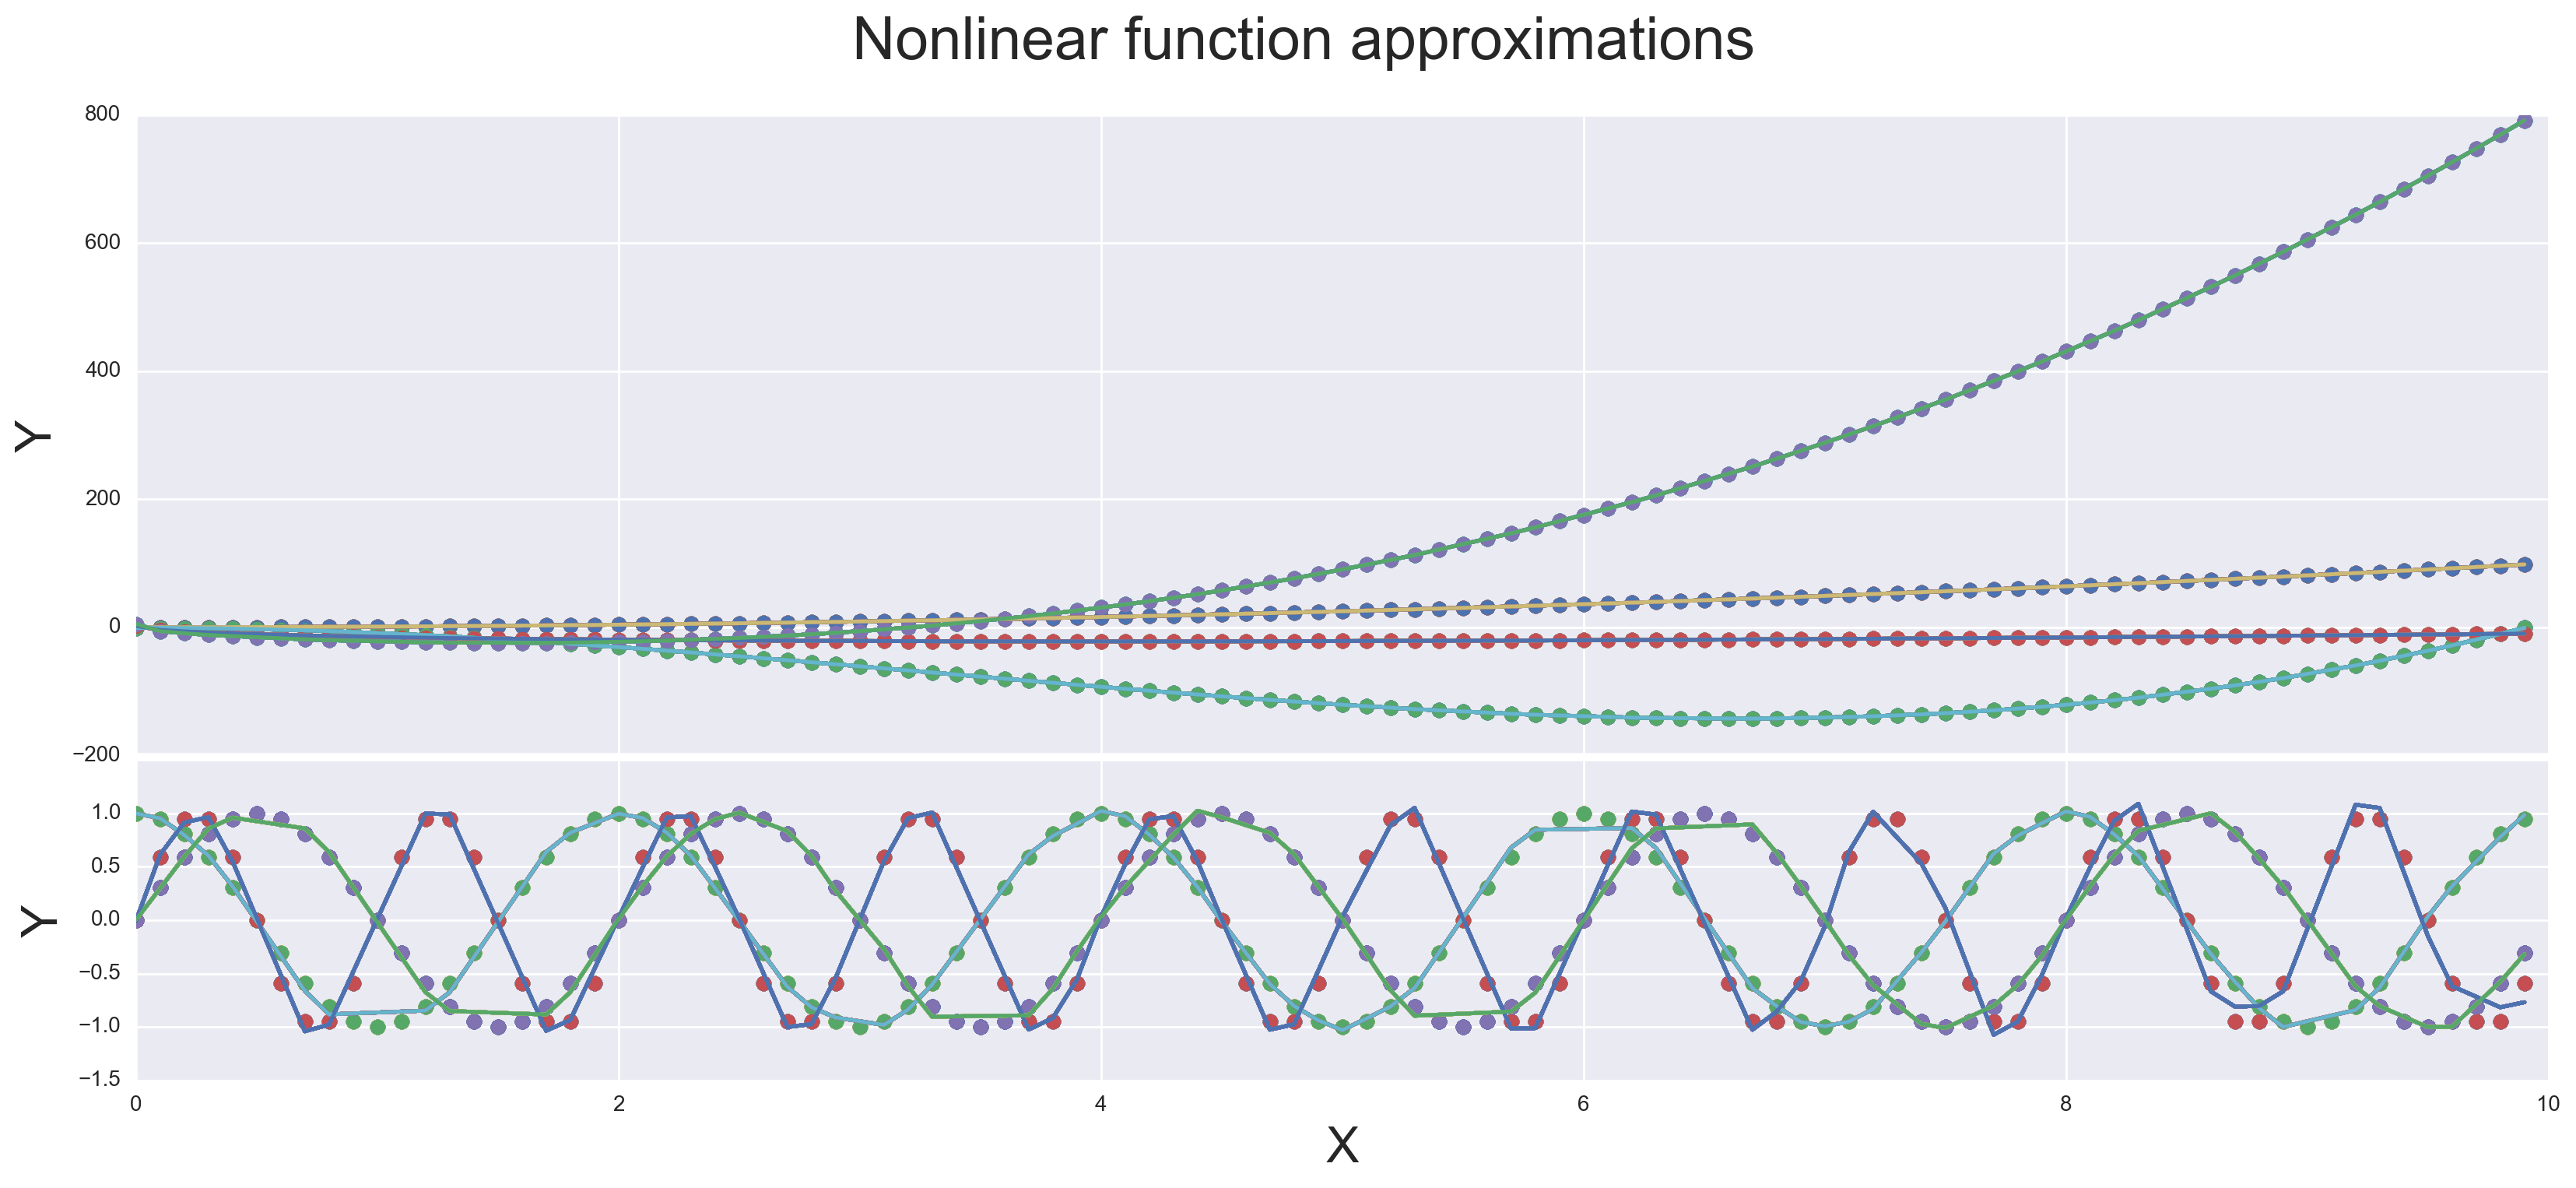

In [7]:
## Compute and visualize approximations

# Make a forward pass with our trained network
FX = net.forward_pass(X)

def plot_approximations(X, Y, FX):
    # Plot on two subplots due to differences in scale

    # h_i(x) for i = 1, 2, 3, 4
    fig = plt.figure()
    fig.suptitle('Nonlinear function approximations', fontsize='xx-large')

    # set height ratios for sublots
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    # the fisrt subplot
    ax0 = plt.subplot(gs[0])
    ax0.plot(X, Y[:, [0, 1, 2, 3]], 'o', linewidth=0.5)
    ax0.plot(X, FX[:, [0, 1, 2, 3]])
    ax0.spines['bottom'].set_visible(True)
    ax0.spines['bottom'].set_linewidth(2)
    plt.ylabel('Y', fontsize='x-large')
    plt.setp(ax0.get_xticklabels(), visible=False)

    # h_i(x) for i = 5, 6, 7
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(X, Y[:, [4, 5, 6]], 'o', linewidth=1)
    ax1.plot(X, FX[:, [4, 5, 6]])
    plt.xlabel('X', fontsize='x-large')
    plt.ylabel('Y', fontsize='x-large')
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    plt.subplots_adjust(hspace=0.01)
    plt.show()
    
plot_approximations(X, Y, FX)

<div class='markdown-body'>
**5.** Graph the final error as a function of number of input nodes $(N)$ as well as number of intermediate nodes $(I)$. What have you learned? What happens if you remove the regularization by setting $C = 0$? Can you explain the relationship between what you’ve learned and the Universal Approximation Theorem (UAT) of Neural Networks?

In [8]:
def error_surface(input_max, hidden_max, step=10, C=1, fns=get_nonlinear_funcs()):

    input_sizes = np.arange(4, input_max, step)
    hidden_sizes = np.arange(4, hidden_max, step)
    X, Y = np.meshgrid(input_sizes, hidden_sizes)
    errors = np.array([final_error(x, y, fns=fns, verb=False)
                       for x, y in zip(np.ravel(X), np.ravel(Y))])
    E = errors.reshape(X.shape)
    return X, Y, E

def plot_surface(X, Y, Z):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5, cmap=cm.Spectral)
    ax.set_xlabel('Inputs')
    ax.set_ylabel('Hidden Units')
    ax.set_zlabel('Error')
    ax.view_init(30, 45)
    plt.show()

In [9]:
N, I, E = error_surface(16, 16, step=2)

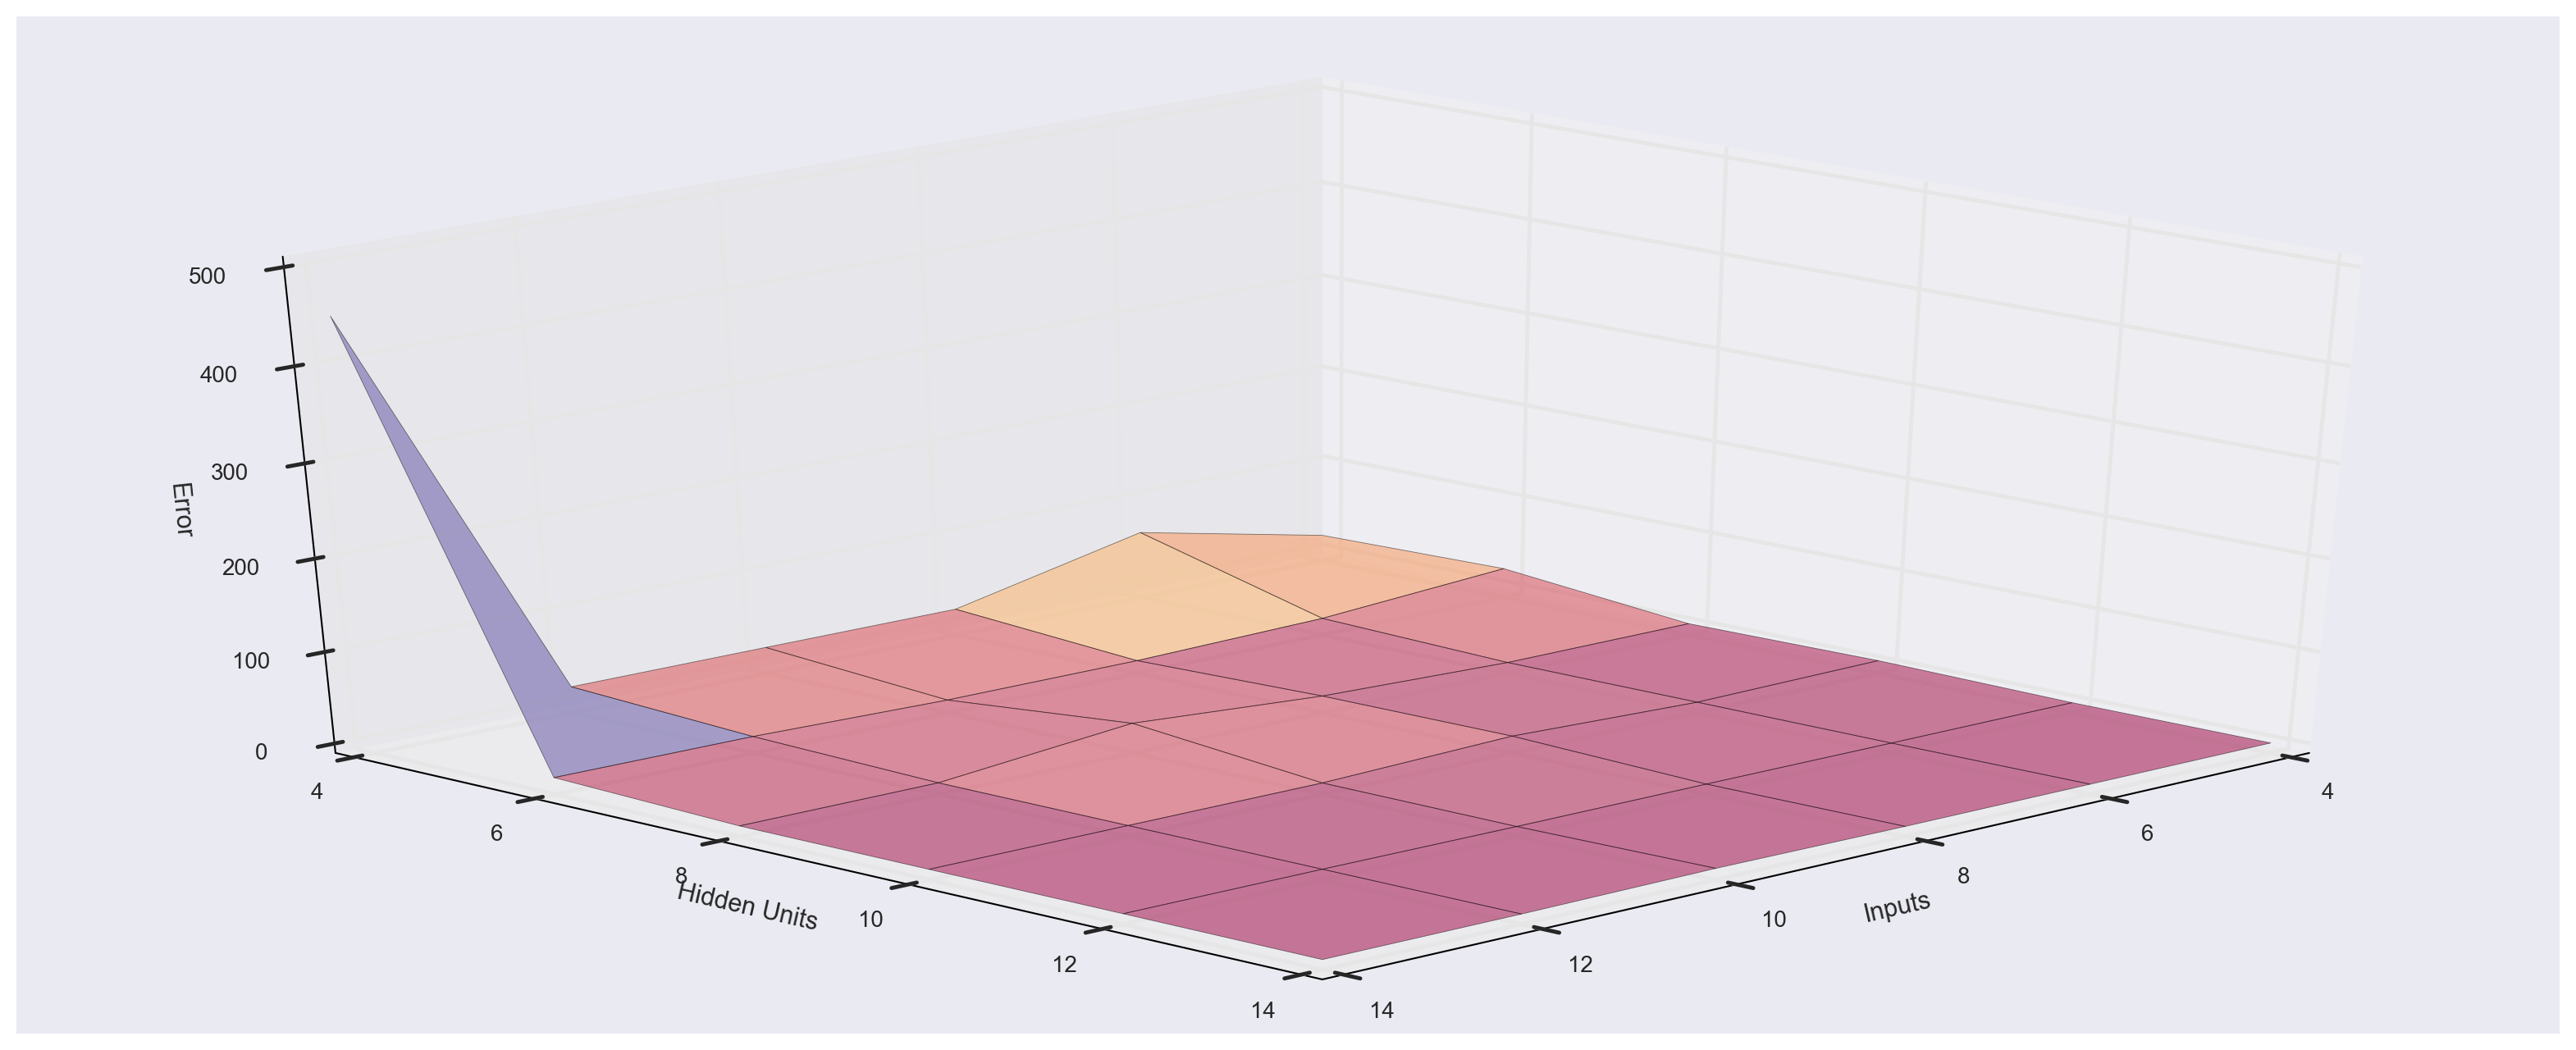

In [10]:
plot_surface(N, I, E)

In [17]:
training_stats0 = net.train(X, Y, C=0, reinitialize=True)

print('Final training error with C = {}: {}'.format(1, training_stats['error_history'][-1]))
print('Final training error with C = {}: {}'.format(0, training_stats0['error_history'][-1]))

Final training error with C = 1: 0.00521274935424
Final training error with C = 0: 0.00638548658391


<div class='markdown-body'>

### Universal Approximation Theorem (UAT)
As we increase the number of input nodes $N$ and intermediate nodes $I$ (the size of the 'hidden' layer), the final error tends to decrease. Now, regularization is a common means of preventing overfitting in a neural network, so the final error of the network evaluated on the same training data should be slightly larger with regularization. Indeed, when $C=0$ (*i.e.*, when regularization is removed), the final error is minutely larger, suggesting that regularization on such a small dataset is not enough to completey prevent overfitting. Additional techniques, such as dropout, may help further to alleviate overfitting.

This observation is in agreement with the Universal Approximation Theorem for neural networks, which informally says that a neural network can approximate any continuous function to any desired precision, given enough hidden neurons. More precisely, the UAT says that given any continuous function $f$ with domain $[0, 1]^m$ and $\epsilon > 0$, there exists $N$, $v_{i},b_{i}\in \mathbb {R}$, and real vectors $w_{i}\in \mathbb {R} ^{m}$ , $i=1,\dots ,N$ , such that the function

$$F(x)=\sum _{{i=1}}^{{N}}v_{i}\varphi \left(w_{i}^{T}x+b_{i}\right)$$

*converges* on $f(x)$ for all $x\in [0, 1]^n$ (where $f$ independent of $\varphi$)[1].


<div class='markdown-body'>
**6.** Perform the same optimization with a tensorflow implementation of the above using tensorflow’s
built-in backpropagation via stochastic gradient descent.

Our class `FullyConnectedNet` allows us to simply switch out backends and proceed via the same API: 


In [12]:
## Create a 2 layer (not including input) net with a Tensorflow backend
## and display its (default) properties:

# Init and display
net_tf = FullyConnectedNet(layer_sizes, backend='tf')  # set tf as the backend
print(net_tf)

Feed-Forward Neural Network with 2 Fully-Connected Layers 
Activation function: Rectified Linear Units (ReLU) 
Loss/Cost function: Regularized Least Squares 
Backend Optimization: Tensorflow Stochastic Gradient Descent 
Network Diagram: 
                 -------- Layer 1 --------      -------- Layer 2 --------      
Inputs (100) --> {affine - relu [100, 100]} --> {affine - reg_mse [100, 7]} --> Outputs (7)


In [24]:
# Generate training data
X, Y = generate_data(net.layer_sizes[0])

# Perform optimization (training) using tf's SGD.
training_stats_tf = net_tf.train(X, Y, num_iter=7.5e4, learning_rate=0.001, verbose=True)

iter: 1000 cost = 1115.050781250, error = 611.871765137
iter: 2000 cost = 502.264068604, error = 45.5422058105
iter: 3000 cost = 415.565521240, error = 16.0957870483
iter: 4000 cost = 355.034088135, error = 10.8059272766
iter: 5000 cost = 300.809631348, error = 8.33820056915
iter: 6000 cost = 249.958938599, error = 6.08106565475
iter: 7000 cost = 204.502136230, error = 4.55929040909
iter: 8000 cost = 162.337890625, error = 3.2306098938
iter: 9000 cost = 123.407875061, error = 2.4281835556
iter: 10000 cost = 87.756317139, error = 1.9062025547
iter: 11000 cost = 57.147434235, error = 1.49990200996
iter: 12000 cost = 34.048908234, error = 1.21123230457
iter: 13000 cost = 19.398935318, error = 1.02247369289
iter: 14000 cost = 11.647046089, error = 0.869042813778
iter: 15000 cost = 7.996831894, error = 0.719613194466
iter: 16000 cost = 6.245122910, error = 0.655342042446
iter: 17000 cost = 5.223546028, error = 0.576020240784
iter: 18000 cost = 4.509757996, error = 0.503545820713
iter: 19000

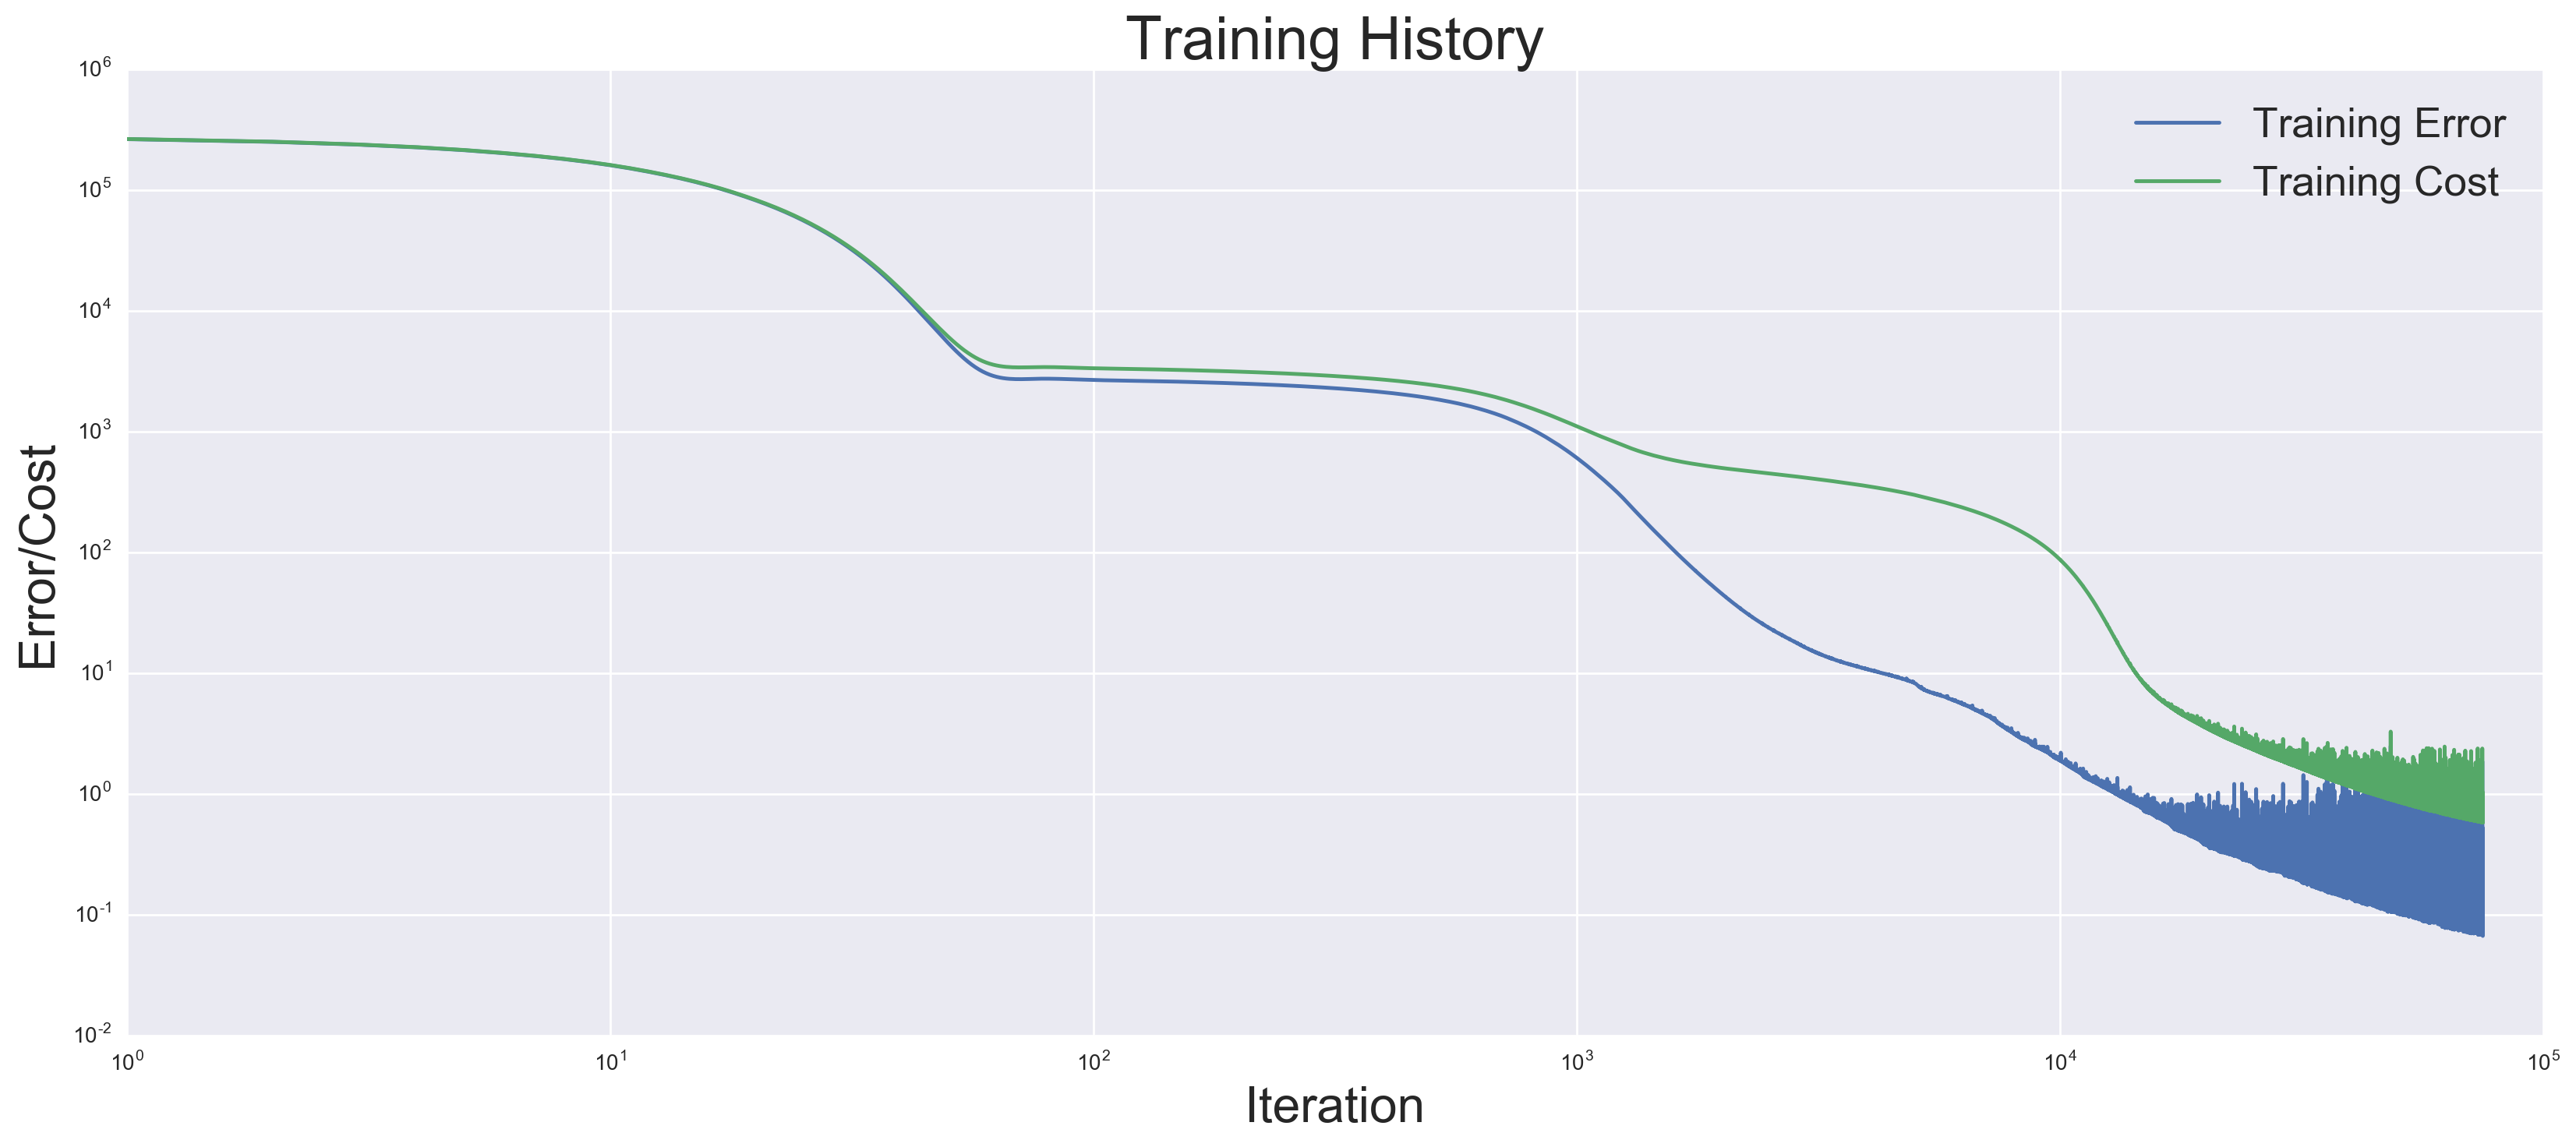

In [25]:
## Plot loglog plot of training history:

plt.loglog(training_stats_tf['error_history'], label='Training Error')
plt.loglog(training_stats_tf['cost_history'], label='Training Cost')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Iteration', fontsize='x-large')
plt.ylabel('Error/Cost', fontsize='x-large')
plt.title('Training History', fontsize='xx-large')
plt.show()

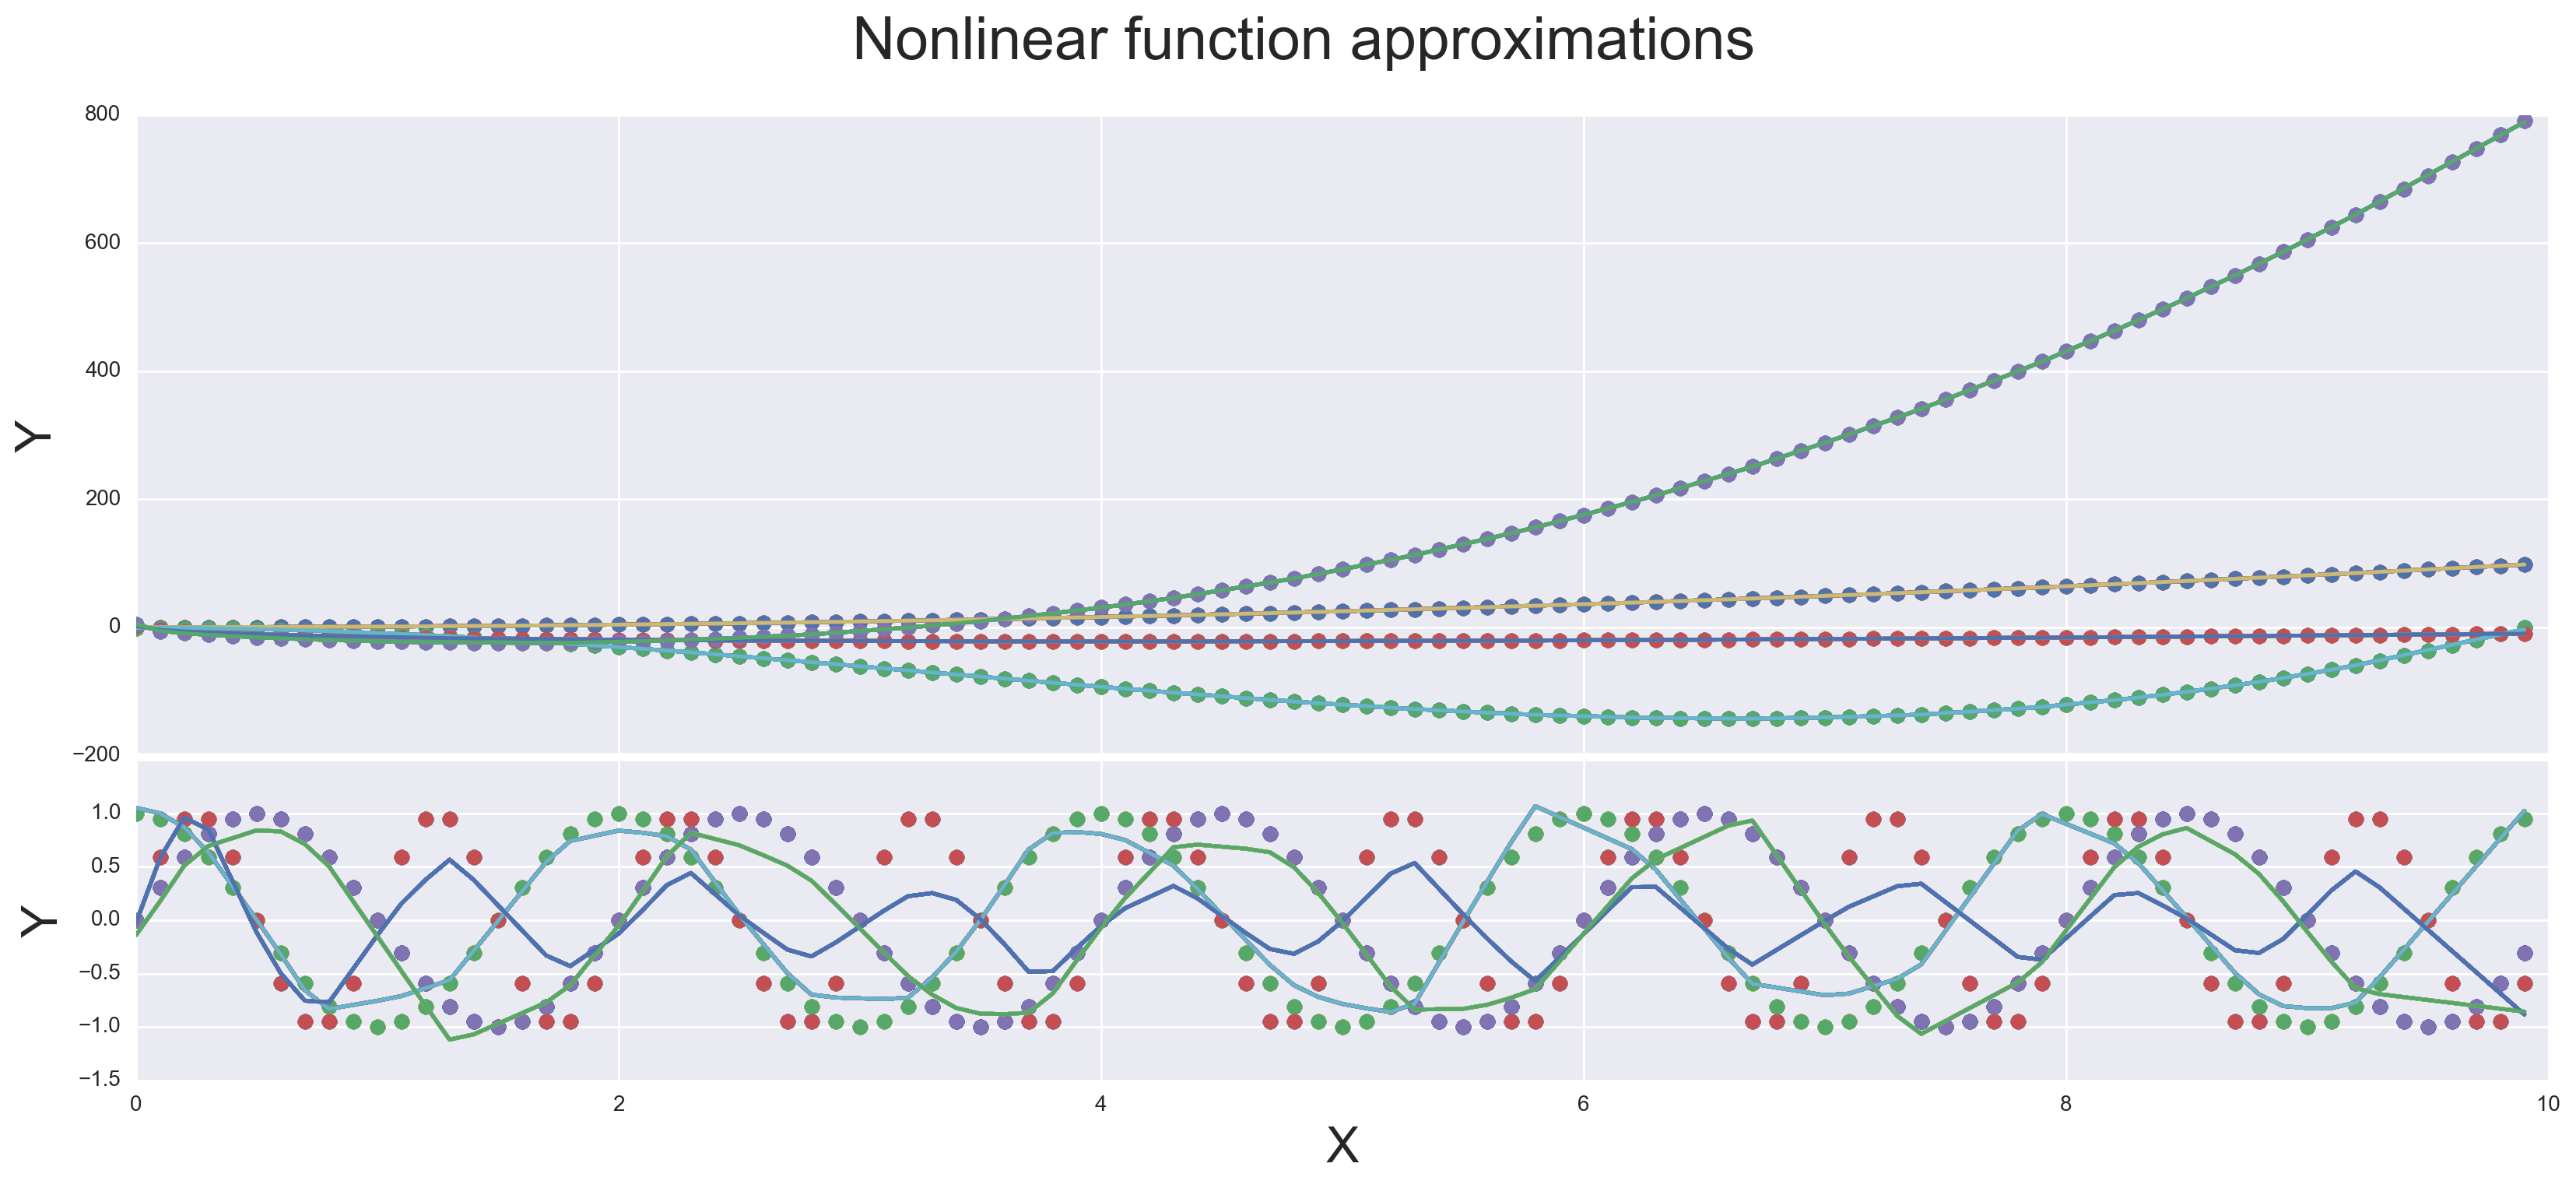

In [26]:
## Compute and visualize approximations

# Make a forward pass with our trained network
FX1 = net_tf.forward_pass(X)
plot_approximations(X, Y, FX1)

### References

1. https://en.wikipedia.org/wiki/Universal_approximation_theorem

<div class='markdown-body'>